# Lesson 6: Essay Writer

In [1]:
from dotenv import load_dotenv

_ = load_dotenv()


In [2]:
from setup_environment_r1 import set_environment_variables
set_environment_variables('Essay-Writing-deeplearning.ai')

reading environment variables from: </home/tjamil/Desktop/Agents/Deeplearning_Ai/Ai Agents using Langgraph>
API Keys loaded and tracing set with project name:  Essay-Writing-deeplearning.ai


In [3]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated, List
import operator
from langgraph.checkpoint.sqlite import SqliteSaver
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage, ChatMessage
from IPython.display import Image, display
import sqlite3
conn = sqlite3.connect("checkpoints.sqlite", check_same_thread=False)
memory = SqliteSaver(conn)

#memory = SqliteSaver.from_conn_string(":memory:")

In [4]:
class AgentState(TypedDict):
    task: str
    plan: str
    draft: str
    critique: str
    content: List[str]
    revision_number: int
    max_revisions: int

In [5]:
#from langchain_openai import ChatOpenAI
#model = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)

from utils import GroqChatLLM, OllamaLLM
#model2 = GroqChatLLM(model_name='llama3-8b-8192')
model2 = OllamaLLM(model_name='gemma2:2b')
model = GroqChatLLM(model_name='llama3-70b-8192')
model.invoke("hello")  # testing

AIMessage(content="Hello! It's nice to meet you. Is there something I can help you with, or would you like to chat?", response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 11, 'total_tokens': 37, 'completion_time': 0.082932196, 'prompt_time': 0.000174279, 'queue_time': 0.01504692, 'total_time': 0.083106475}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_87cbfbbc4d', 'finish_reason': 'stop', 'logprobs': None}, id='run-90005850-c1c6-417f-b447-f3a21359115e-0', usage_metadata={'input_tokens': 11, 'output_tokens': 26, 'total_tokens': 37})

In [6]:
PLAN_PROMPT = """You are an expert writer tasked with writing a high level outline of an essay. \
Write such an outline for the user provided topic. Give an outline of the essay along with any relevant notes \
or instructions for the sections."""

In [7]:
WRITER_PROMPT = """You are an essay assistant tasked with writing excellent 5-paragraph essays.\
Generate the best essay possible for the user's request and the initial outline. \
If the user provides critique, respond with a revised version of your previous attempts. \
Utilize all the information below as needed: 

------

{content}"""

In [8]:
REFLECTION_PROMPT = """You are a teacher grading an essay submission. \
Generate critique and recommendations for the user's submission. \
Provide detailed recommendations, including requests for length, depth, style, etc."""

In [9]:
RESEARCH_PLAN_PROMPT = """You are a researcher charged with providing information that can \
be used when writing the following essay. Generate a list of search queries that will gather \
any relevant information. Only generate 3 queries max."""


In [10]:
RESEARCH_CRITIQUE_PROMPT = """You are a researcher charged with providing information that can \
be used when making any requested revisions (as outlined below). \
Generate a list of search queries that will gather any relevant information. Only generate 3 queries max."""


In [11]:
from langchain_core.pydantic_v1 import BaseModel

class Queries(BaseModel):
    queries: List[str]

In [12]:
from tavily import TavilyClient
import os
tavily = TavilyClient(api_key=os.environ["TAVILY_API_KEY"])

In [13]:
def plan_node(state: AgentState):
    messages = [
        SystemMessage(content=PLAN_PROMPT), 
        HumanMessage(content=state['task'])
    ]
    response = model.invoke(messages)
    return {"plan": response.content}

In [14]:
def research_plan_node(state: AgentState):

    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_PLAN_PROMPT),
        HumanMessage(content=state['task'])
    ])
    
    content = state.get('content', []) #or state['content'] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {"content": content}

In [15]:
def generation_node(state: AgentState):
    
    content = "\n\n".join(state.get('content', [])) #or state['content'] or [])
    user_message = HumanMessage(
        content=f"{state['task']}\n\nHere is my plan:\n\n{state['plan']}")
    messages = [
        SystemMessage(
            content=WRITER_PROMPT.format(content=content)
        ),
        user_message
        ]
    response = model2.invoke(messages)
    return {
        "draft": response.content, 
        "revision_number": state.get("revision_number", 1) + 1
    }

In [16]:
def reflection_node(state: AgentState):
    messages = [
        SystemMessage(content=REFLECTION_PROMPT), 
        HumanMessage(content=state['draft'])
    ]
    response = model.invoke(messages)
    return {"critique": response.content}

In [17]:
def research_critique_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_CRITIQUE_PROMPT),
        HumanMessage(content=state['critique'])
    ])
    content = state.get('content', []) #or state['content'] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {"content": content}

In [18]:
def should_continue(state):
    if state["revision_number"] > state["max_revisions"]:
        return END
    return "reflect"

In [19]:
builder = StateGraph(AgentState)

In [20]:
builder.add_node("planner", plan_node)
builder.add_node("generate", generation_node)
builder.add_node("reflect", reflection_node)
builder.add_node("research_plan", research_plan_node)
builder.add_node("research_critique", research_critique_node)

In [21]:
builder.set_entry_point("planner")

In [22]:
builder.add_conditional_edges(
    "generate", 
    should_continue, 
    {END: END, "reflect": "reflect"}
)

In [23]:
builder.add_edge("planner", "research_plan")
builder.add_edge("research_plan", "generate")

builder.add_edge("reflect", "research_critique")
builder.add_edge("research_critique", "generate")

In [24]:
graph = builder.compile(checkpointer=memory)

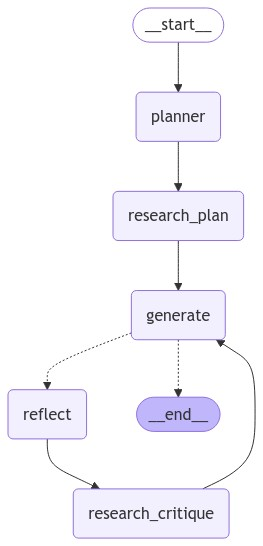

In [25]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [26]:
thread = {"configurable": {"thread_id": "1"}}
for s in graph.stream({
    #'task': "what is the difference between langchain and langsmith",
    'task': "why AI Agents are gaining so much momentum?",
    
    "max_revisions": 2,
    "revision_number": 1,}, thread):
    print(s)

{'planner': {'plan': 'Here is a high-level outline for an essay on "Why AI Agents are Gaining So Much Momentum":\n\n**I. Introduction**\n\n* Hook: AI agents are transforming industries and revolutionizing the way we live and work\n* Background: Briefly introduce AI agents and their increasing presence in various sectors\n* Thesis statement: AI agents are gaining momentum due to their ability to automate tasks, enhance customer experience, and drive business efficiency\n\n**II. Automation and Efficiency**\n\n* Discuss how AI agents can automate repetitive and mundane tasks, freeing up human resources for more strategic and creative work\n* Provide examples of industries where AI agents are being used for automation, such as customer service, data entry, and bookkeeping\n* Note: Use specific statistics or case studies to illustrate the benefits of automation\n\n**III. Enhanced Customer Experience**\n\n* Explain how AI agents can provide 24/7 customer support, personalized interactions, a

In [29]:
thread = {"configurable": {"thread_id": "1"}}

result = graph.invoke({
    #'task': "what is the difference between langchain and langsmith",
    'task': "why AI Agents are gaining so much momentum?",
    
    "max_revisions": 2,
    "revision_number": 1,}, thread)

print(result)

{'task': 'why AI Agents are gaining so much momentum?', 'plan': 'Here is a high-level outline for an essay on "Why AI Agents are gaining so much momentum":\n\n**I. Introduction**\n\n* Hook: AI agents are transforming industries and revolutionizing the way we live and work\n* Background: Briefly introduce AI agents and their increasing presence in various sectors\n* Thesis statement: AI agents are gaining momentum due to their ability to automate tasks, enhance customer experience, and drive business efficiency\n\n**II. Automation and Efficiency**\n\n* Discuss how AI agents can automate repetitive and mundane tasks, freeing up human resources for more strategic and creative work\n* Provide examples of industries where AI agents are being used for automation, such as customer service, data entry, and bookkeeping\n* Note: Use specific statistics or case studies to illustrate the benefits of automation, such as increased productivity and cost savings\n\n**III. Enhanced Customer Experience*

In [30]:
result.keys()

dict_keys(['task', 'plan', 'draft', 'critique', 'content', 'revision_number', 'max_revisions'])

## Essay Writer Interface

#run notebook 'Test6_gradio.ipynb'